In [7]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   ----- ---------------------------------- 92.2/626.3 kB 1.3 MB/s eta 0:00:01
   -------------------------------- ------- 512.0/626.3 kB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 4.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
from __future__ import print_function
import sys
%matplotlib inline
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer

# Read the csv file

In [33]:
input_df= pd.read_csv("C:/Users/dixit/Desktop/twitter sentiment/Tweets.csv")

In [35]:
input_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Analysing the data and getting some insights

The shape of the table: rows=14640, columns=15. Each row corresponds to one twitter user.

In [45]:
input_df.shape, input_df.columns

((14640, 15),
 Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
        'negativereason', 'negativereason_confidence', 'airline',
        'airline_sentiment_gold', 'name', 'negativereason_gold',
        'retweet_count', 'text', 'tweet_coord', 'tweet_created',
        'tweet_location', 'user_timezone'],
       dtype='object'))

In [47]:
input_df["airline"].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

There are 3 different categories of sentiments -"positive","negative","neutral"

In [52]:
input_df["airline_sentiment"].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

Checking for any null entries, with particular emphasis on whether the "text" entries are blank. As follows, there is no empty "text" entry. We do not need to deal with missing entry problem. 


In [57]:
input_df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

No. of "Positive", "negative" and "neutral" sentiments per airline

In [68]:
sentiments_per_airline=pd.crosstab(input_df["airline_sentiment"],input_df["airline"])
sentiments_per_airline

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,1960,955,1186,2263,2633,181
neutral,463,723,664,381,697,171
positive,336,544,570,269,492,152


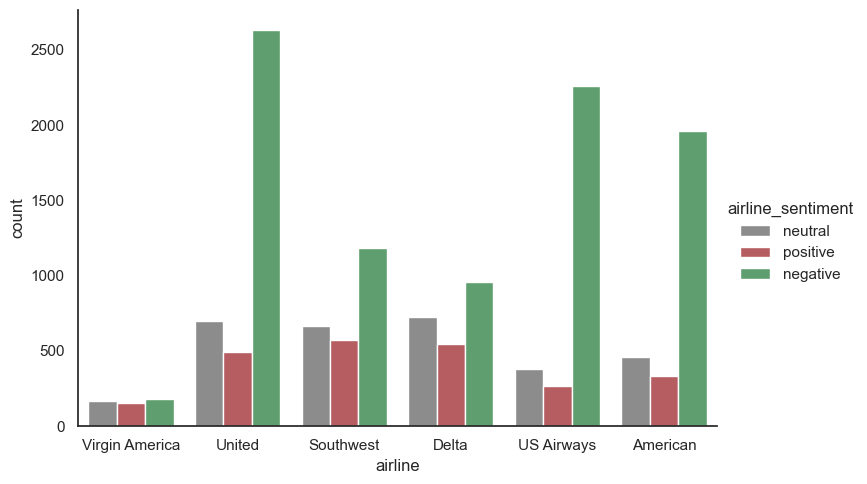

In [72]:
palette = {"positive":"C3", "negative":"C2", "neutral":"C7"}
with sns.axes_style("white"):
    sns.catplot(x="airline", data=input_df, aspect=1.5,
                hue='airline_sentiment', kind='count', palette=palette)

The table "sentiments_per_airline" is not an effective way to measure sentiment ratings, as the number of passengers varies across airlines. For example, Virgin America has only 504 passengers in total, whereas United has 3,822 passengers.

A more accurate comparison can be made by calculating the percentage of positive, negative, and neutral ratings.

In [75]:
p = sentiments_per_airline.apply(lambda x: x / x.sum() * 100.0)
p

airline,American,Delta,Southwest,US Airways,United,Virgin America
airline_sentiment,,,,,,
negative,71.040232,42.979298,49.008264,77.686234,68.890633,35.912698
neutral,16.781443,32.538254,27.438017,13.079300,18.236525,33.928571
positive,12.178325,24.482448,23.553719,9.234466,12.872841,30.158730


Text(0, 0.5, 'percent of passengers')

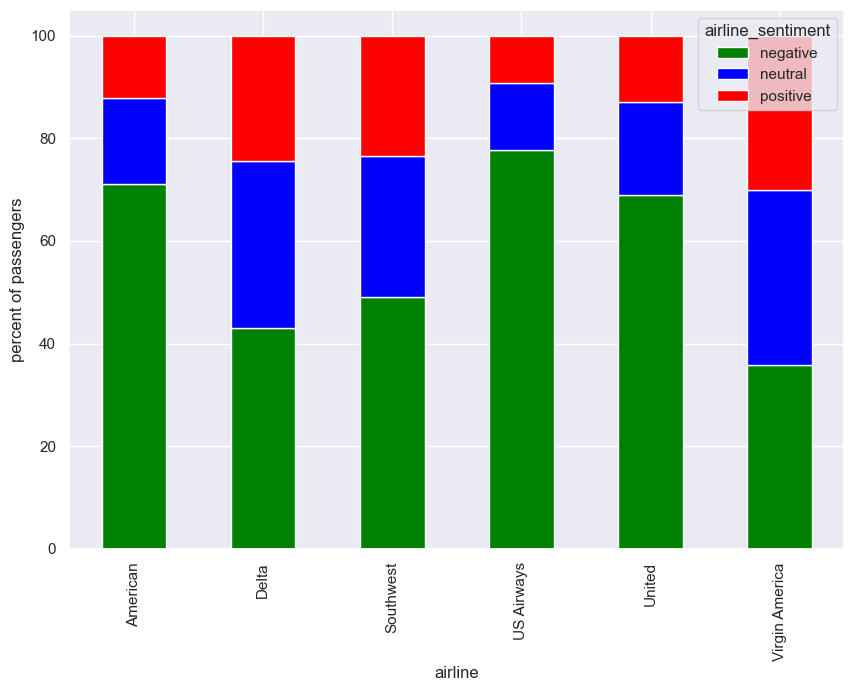

In [77]:
my_colors = ['green', 'blue', 'red']
p.T.plot(kind='bar', figsize=(10, 7), stacked=True, color=my_colors)
plt.ylabel('percent of passengers')

In [79]:
input_df["negativereason"].value_counts()

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64

In [85]:
from wordcloud import WordCloud, STOPWORDS

In [83]:
!pip install wordcloud

   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   -- ------------------------------------ 20.5/301.4 kB 640.0 kB/s eta 0:00:01
   --------- ----------------------------- 71.7/301.4 kB 777.7 kB/s eta 0:00:01
   ---------------------------------------  297.0/301.4 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 301.4/301.4 kB 2.3 MB/s eta 0:00:00


In [87]:
df = input_df[input_df['airline_sentiment'] == 'negative']
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                         if 'http' not in word
                         and not word.startswith('@')
                         and word != 'RT'
                        ])

In [89]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

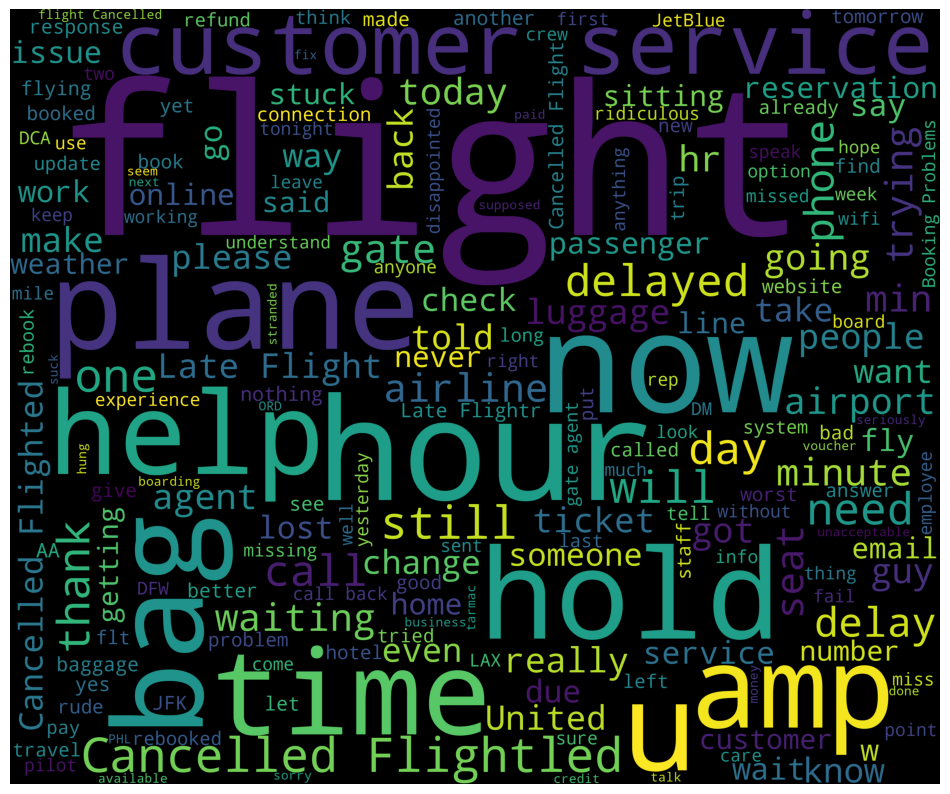

In [91]:
plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

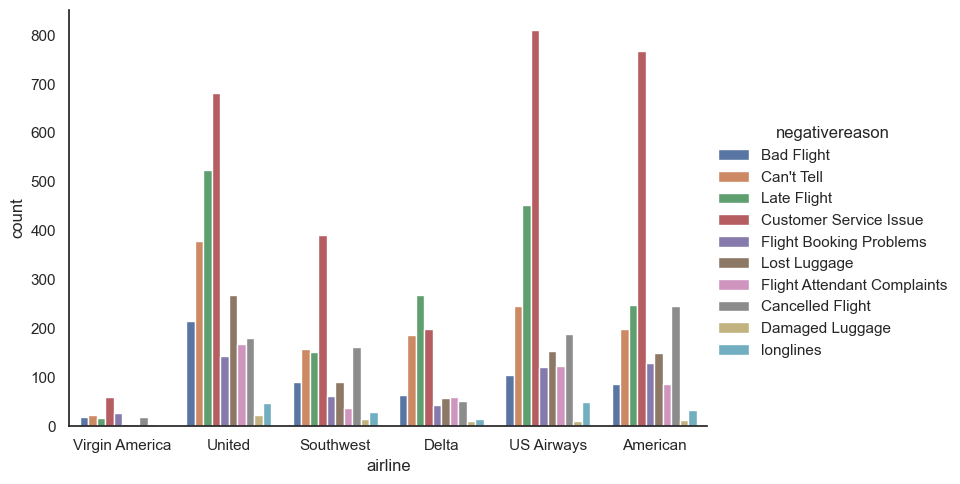

In [93]:
df = input_df.groupby(['airline', 'negativereason'])
df = df['airline_sentiment'].value_counts()

with sns.axes_style("white"):
    sns.catplot(x="airline", data=input_df, aspect=1.5,
                hue='negativereason', kind='count')

In [95]:
input_df["negativereason"].isnull().sum()

5462

Approximately 40% (5462 out of 14,640) of the 'negativereason' rows are empty. Therefore, we will use only the 'text' column as the feature (X) for our model.

## Data Processing

In [103]:
X = input_df['text']
y = input_df['airline_sentiment']

Split data into train and test

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_train.shape, y_train.shape

((7320,), (7320,))

We will use scikit-learn’s feature extraction tool, Term Frequency-Inverse Document Frequency (Tf-idf). For more details, please refer to this Wikipedia article.

To improve our model's performance, we will reduce the vocabulary by removing stopwords using the "english" library, which will eliminate redundant words such as "a", "the", and "about."

In [112]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', normalize=True):
    cmap = plt.get_cmap('Reds')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 1. Naive Bayes Classifier

In [119]:
from sklearn.naive_bayes import MultinomialNB

parameters = {"alpha": [1.0, 5.0, 10.0, 50.0, 100.0]}
tfidf = TfidfVectorizer(stop_words='english')
clf = GridSearchCV(MultinomialNB(), parameters, cv=2, refit=True)
model = make_pipeline(tfidf, clf)

model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('gridsearchcv',
                 GridSearchCV(cv=2, estimator=MultinomialNB(),
                              param_grid={'alpha': [1.0, 5.0, 10.0, 50.0,
                                                    100.0]}))])

Best parameters set: {'alpha': 1.0}
Grid scores on every set of parameters:

0.644 (+/-0.003) for {'alpha': 1.0}
0.621 (+/-0.001) for {'alpha': 5.0}
0.621 (+/-0.000) for {'alpha': 10.0}
0.621 (+/-0.000) for {'alpha': 50.0}
0.621 (+/-0.000) for {'alpha': 100.0}

Classification report:
              precision    recall  f1-score   support

    negative       0.67      1.00      0.80      4634
     neutral       0.77      0.12      0.21      1510
    positive       0.91      0.15      0.26      1176

    accuracy                           0.68      7320
   macro avg       0.79      0.42      0.43      7320
weighted avg       0.73      0.68      0.59      7320

Test accuracy: 0.6806010928961749


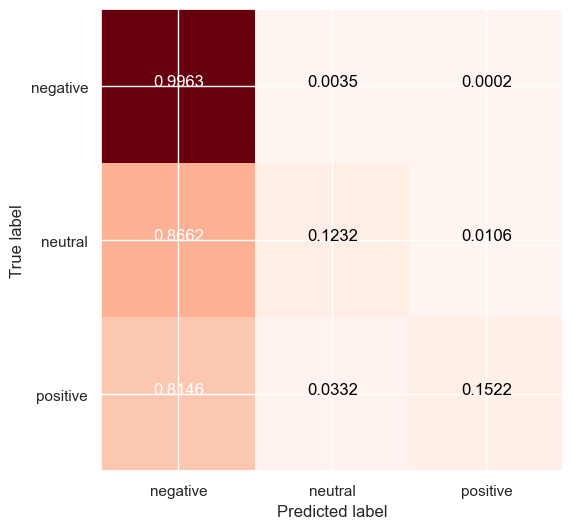

In [121]:
print("Best parameters set:", clf.best_params_)
print("Grid scores on every set of parameters:")
print()

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print("\nClassification report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print("Test accuracy:", accuracy_score(y_test, y_pred))

labels = model.classes_
matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(matrix, columns=labels, index=labels)
plot_confusion_matrix(matrix, labels)

# 2. Logistic Regression

In [175]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
url = "C:/Users/dixit/Desktop/twitter sentiment/Tweets.csv"
df = pd.read_csv(url)
df = df[['text', 'airline_sentiment']]
df['text'] = df['text'].str.lower()
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['airline_sentiment'] = df['airline_sentiment'].map(sentiment_mapping)
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['text']).toarray()
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 5: Train the Logistic Regression Model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8036202185792349

Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.93      0.88      1889
     Neutral       0.67      0.53      0.59       580
    Positive       0.80      0.61      0.69       459

    accuracy                           0.80      2928
   macro avg       0.77      0.69      0.72      2928
weighted avg       0.80      0.80      0.79      2928


Confusion Matrix:
 [[1766   93   30]
 [ 233  307   40]
 [ 119   60  280]]


# 3. Support Vector Machines

Best parameters set: {'C': 1, 'kernel': 'linear'}
Grid scores on every set of parameters:

0.763 (+/-0.004) for {'C': 1, 'kernel': 'linear'}
0.725 (+/-0.011) for {'C': 10, 'kernel': 'linear'}
0.701 (+/-0.009) for {'C': 100, 'kernel': 'linear'}
0.625 (+/-0.004) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.622 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.622 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.692 (+/-0.006) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.625 (+/-0.004) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.622 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.757 (+/-0.002) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.692 (+/-0.006) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.625 (+/-0.004) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.715 (+/-0.010) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.757 (+/-0.003) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.692 (+/-0.006) for {'C': 1000, 'gamma': 0.0001,

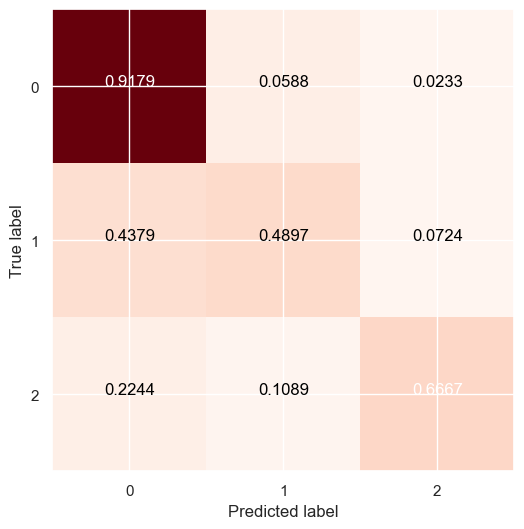

In [188]:
parameters = [
    {'kernel': ['linear'], 'C': [1, 10, 100]},
    {'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4], 'C': [1, 10, 100, 1000]}
]

# Ensure X_train and X_test are in string format
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Create the TfidfVectorizer and SVC pipeline
tfidf = TfidfVectorizer(stop_words='english')
clf = GridSearchCV(SVC(), parameters, cv=2, refit=True)
model = make_pipeline(tfidf, clf)

# Fit the model
model.fit(X_train, y_train)

# Output the best parameters
print("Best parameters set:", clf.best_params_)
print("Grid scores on every set of parameters:\n")

# Extract and print the mean test scores and standard deviations
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Predict and evaluate
print("\nClassification report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print("Test accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
labels = model.classes_
matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(matrix, columns=labels, index=labels)
plot_confusion_matrix(matrix, labels)

# 4 Random Forest Classifier

Best parameters set: {'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'n_estimators': 250}
Grid scores on every set of parameters:

0.726 (+/-0.004) for {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 50}
0.731 (+/-0.000) for {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 250}
0.729 (+/-0.008) for {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 300}
0.728 (+/-0.001) for {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 50}
0.730 (+/-0.004) for {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 250}
0.729 (+/-0.001) for {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'n_estimators': 300}
0.725 (+/-0.001) for {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'n_estimators': 50}
0.731 (+/-0.002) for {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'n_estimators': 250}
0.733 (+/-0.001) for {'criterion': 'gi

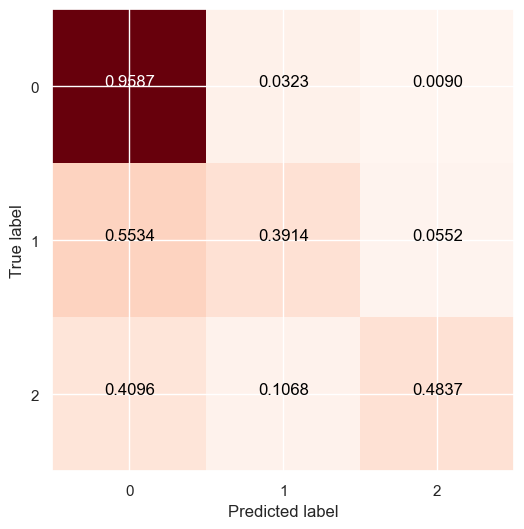

In [190]:
parameters = {
    "max_depth": [None],
    "max_features": [1, 3, 10],
    "criterion": ["gini", "entropy"],
    "n_estimators": [50, 250, 300]
}

# Create the TfidfVectorizer and RandomForestClassifier pipeline
tfidf = TfidfVectorizer(stop_words='english')
clf = GridSearchCV(RandomForestClassifier(), parameters, cv=2, refit=True)
model = make_pipeline(tfidf, clf)

# Fit the model
model.fit(X_train, y_train)

# Output the best parameters
print("Best parameters set:", clf.best_params_)
print("Grid scores on every set of parameters:\n")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Predict and evaluate
print("\nClassification report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

print("Test accuracy:", accuracy_score(y_test, y_pred))

# Confusion matrix
labels = model.classes_
matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(matrix, columns=labels, index=labels)
plot_confusion_matrix(matrix, labels)

# 5 K-Nearest-Neighbors Classifiers

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Accuracy: 0.7288251366120219

Classification Report:
               precision    recall  f1-score   support

    Negative       0.81      0.84      0.83      1889
     Neutral       0.50      0.48      0.49       580
    Positive       0.64      0.59      0.62       459

    accuracy                           0.73      2928
   macro avg       0.65      0.64      0.64      2928
weighted avg       0.72      0.73      0.73      2928


Confusion Matrix:
 [[1584  208   97]
 [ 249  277   54]
 [ 115   71  273]]
Best parameters set: {'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}


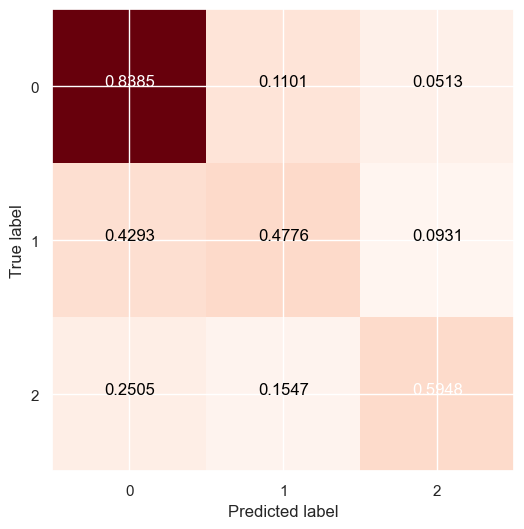

In [211]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline

# Load and preprocess the dataset
url = "C:/Users/dixit/Desktop/twitter sentiment/Tweets.csv"
df = pd.read_csv(url)
df = df[['text', 'airline_sentiment']]
df['text'] = df['text'].str.lower()  # Lowercase the text data
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['airline_sentiment'] = df['airline_sentiment'].map(sentiment_mapping)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.2, random_state=42)

# Define the TfidfVectorizer and KNeighborsClassifier
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
knn = KNeighborsClassifier()

# Define parameter grid for GridSearchCV
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Create a pipeline with TfidfVectorizer and GridSearchCV for KNeighborsClassifier
pipeline = make_pipeline(tfidf, GridSearchCV(knn, parameters, cv=5, n_jobs=-1, verbose=1))

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Access the GridSearchCV object and print the best parameters
clf = pipeline.named_steps['gridsearchcv']
print("Best parameters set:", clf.best_params_)

# Confusion matrix
labels = model.classes_
matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(matrix, columns=labels, index=labels)
plot_confusion_matrix(matrix, labels)


# 6 Decision Tree Classifiers 

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Accuracy: 0.7096994535519126

Classification Report:
               precision    recall  f1-score   support

    Negative       0.76      0.90      0.82      1889
     Neutral       0.44      0.28      0.34       580
    Positive       0.67      0.48      0.56       459

    accuracy                           0.71      2928
   macro avg       0.62      0.55      0.57      2928
weighted avg       0.68      0.71      0.69      2928


Confusion Matrix:
 [[1696  131   62]
 [ 374  162   44]
 [ 162   77  220]]
Best parameters set: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20, 'splitter': 'random'}


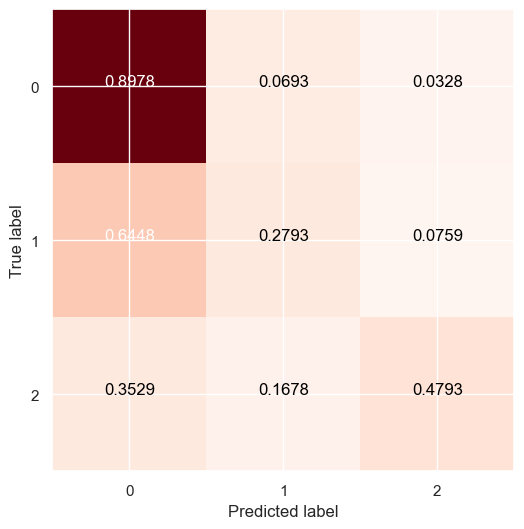

In [213]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline

# Load and preprocess the dataset
url = "C:/Users/dixit/Desktop/twitter sentiment/Tweets.csv"
df = pd.read_csv(url)
df = df[['text', 'airline_sentiment']]
df['text'] = df['text'].str.lower()  # Lowercase the text data
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['airline_sentiment'] = df['airline_sentiment'].map(sentiment_mapping)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.2, random_state=42)

# Define the TfidfVectorizer and DecisionTreeClassifier
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
dtree = DecisionTreeClassifier(random_state=42)

# Define parameter grid for GridSearchCV
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Create a pipeline with TfidfVectorizer and GridSearchCV for DecisionTreeClassifier
pipeline = make_pipeline(tfidf, GridSearchCV(dtree, parameters, cv=5, n_jobs=-1, verbose=1))

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Access the GridSearchCV object and print the best parameters
clf = pipeline.named_steps['gridsearchcv']
print("Best parameters set:", clf.best_params_)

# Confusion matrix
labels = model.classes_
matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(matrix, columns=labels, index=labels)
plot_confusion_matrix(matrix, labels)


# 7 AdaBoost Classifiers 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\dixit\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.7438524590163934

Classification Report:
               precision    recall  f1-score   support

    Negative       0.81      0.88      0.84      1889
     Neutral       0.51      0.41      0.45       580
    Positive       0.68      0.62      0.65       459

    accuracy                           0.74      2928
   macro avg       0.67      0.64      0.65      2928
weighted avg       0.73      0.74      0.74      2928


Confusion Matrix:
 [[1654  163   72]
 [ 281  239   60]
 [ 103   71  285]]
Best parameters set: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}


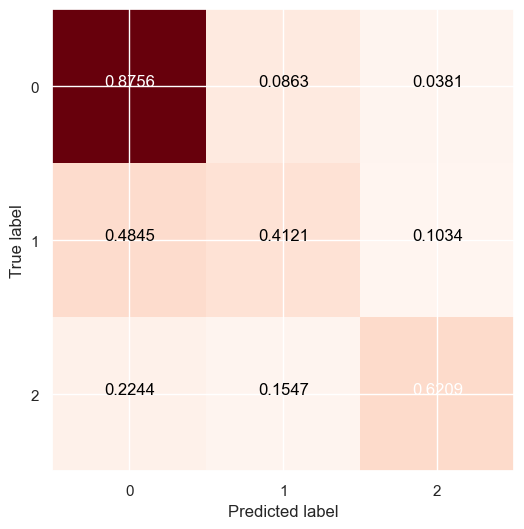

In [221]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# Load and preprocess the dataset
url = "C:/Users/dixit/Desktop/twitter sentiment/Tweets.csv"
df = pd.read_csv(url)
df = df[['text', 'airline_sentiment']]
df['text'] = df['text'].str.lower()  # Lowercase the text data
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['airline_sentiment'] = df['airline_sentiment'].map(sentiment_mapping)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.2, random_state=42)

# Define the TfidfVectorizer and AdaBoostClassifier
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
adaboost = AdaBoostClassifier(estimator=base_estimator, random_state=42)  # Use 'estimator' instead of 'base_estimator'

# Define parameter grid for GridSearchCV
parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Create a pipeline with TfidfVectorizer and GridSearchCV for AdaBoostClassifier
pipeline = make_pipeline(tfidf, GridSearchCV(adaboost, parameters, cv=5, n_jobs=-1, verbose=1))

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Access the GridSearchCV object and print the best parameters
clf = pipeline.named_steps['gridsearchcv']
print("Best parameters set:", clf.best_params_)

# Confusion matrix
labels = model.classes_
matrix = confusion_matrix(y_test, y_pred)
matrix_df = pd.DataFrame(matrix, columns=labels, index=labels)
plot_confusion_matrix(matrix, labels)


# Comparing the Multiple Classifiers

In [230]:
# Define the classifiers to be evaluated
Classifiers = [
    LogisticRegression(max_iter=1000, random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    AdaBoostClassifier(random_state=42)
]

In [236]:
# Split the data into training and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
# Vectorize the text data using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
train_features = vectorizer.fit_transform(train['text'])
test_features = vectorizer.transform(test['text'])

# Convert sparse matrix to dense (if needed for some classifiers)
dense_features = train_features.toarray()
dense_test = test_features.toarray()
# Initialize lists to store accuracy and model names
Accuracy = []
Model = []

# Iterate over the classifiers and evaluate them
for classifier in Classifiers:
    try:
        fit = classifier.fit(train_features, train['airline_sentiment'])
        pred = fit.predict(test_features)
    except Exception:
        fit = classifier.fit(dense_features, train['airline_sentiment'])
        pred = fit.predict(dense_test)
    
    accuracy = accuracy_score(test['airline_sentiment'], pred)
    Accuracy.append(accuracy)
    Model.append(classifier.__class__.__name__)
    print(f'Accuracy of {classifier.__class__.__name__} is {accuracy}')

Accuracy of LogisticRegression is 0.7889344262295082
Accuracy of KNeighborsClassifier is 0.70525956284153
Accuracy of DecisionTreeClassifier is 0.6700819672131147


C:\Users\dixit\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy of AdaBoostClassifier is 0.7298497267759563


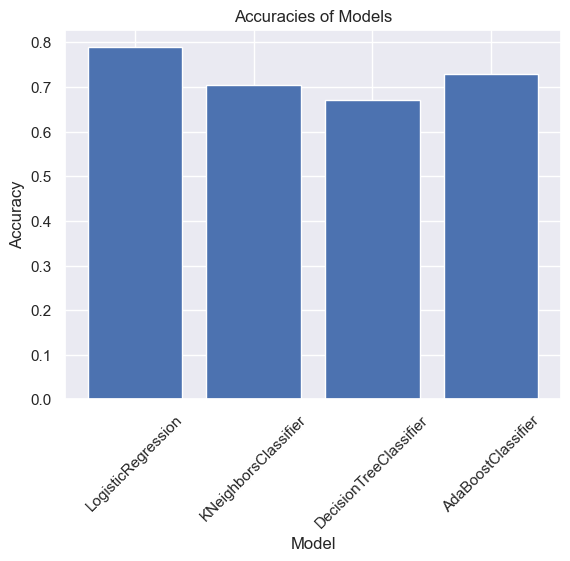

In [238]:
Index = list(range(1, len(Classifiers) + 1))
plt.bar(Index, Accuracy)
plt.xticks(Index, Model, rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show()